In [3]:
from skimage import feature as ft
import cv2

# def Get_Path(dataPath):     # 从数据集（.csv文件）中一次性获取每张图片的绝对路径
#     csvFile = open(dataPath, "r")
#     reader = csv.reader(csvFile)
#     data= []
#     for item in reader:
#         if reader.line_num == 1:
#                 continue
#         data.append(item[0])
#     csvFile.close()      
#     data = np.array(data)
#     return data

def Get_HOG_NP(HOG_data):
    HOG_NP = []
    for path in HOG_data:
        #print(path)
        path = str(path)
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (224,224))
        #print (img.shape)
        #normalised_blocks, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(8, 8), block_norm='L2-Hys',visualize=True)
        features = ft.hog(img,
                        orientations=9,    
                        pixels_per_cell=[16,16],
                        cells_per_block=[2,2],
                        visualize=False,
                        feature_vector= True)
        # print( type(features) )
        # print(features.shape)
        HOG_NP.append(features)
    HOG_NP = np.array(HOG_NP)
    # print(HOG_NP.shape)
    # print(HOG_NP.dtype)

    # pca = PCA(n_components=64,copy=False)
    # HOG_NP = pca.fit_transform(HOG_NP)

    # lda = LDA(n_components=1)
    # HOG_NP = lda.fit_transform(HOG_NP,labels)
    return HOG_NP


In [9]:
from torchvision import transforms
from torch.utils.data import Dataset
import csv
import numpy as np

data_transform  = transforms.Compose( [lambda x: Image.open(x).convert('RGB'),
                                                 # transforms.CenterCrop(300),
                                                 # transforms.Resize((224, 224)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


class MyDataSet(Dataset):  #两个私有成员函数必须被重载:__len__() 和 __getitem__() 方法
    def __init__(self,mode,data,labels):
        self.data = data    #此时 data 还是图片的路径
        self.labels = labels
        self.transforms = data_transform 
        
    def __getitem__(self, index):
        
        path = self.data[index] # 保存此图片的路径

        data = self.transforms(self.data[index])  # 拿到此图片路径后进行transform
        label = torch.tensor(int(self.labels[index]))
        
        return data,label,path  #将准备好的要传进forward里的图片数据 同 此图片的路径一同打包进Mini_batch  
                               #这样就能保证Mini_batch中 图片数据和路径是对应的

    def __len__(self):
         return len(self.labels)


def getDataSet(mode,dataPath):
    csvFile = open(dataPath, "r")
    reader = csv.reader(csvFile)
    data= []
    label = []
    for item in reader:
        if reader.line_num == 1:
                continue
        data.append(item[0])
        label.append(int(item[1]))
    csvFile.close()
    data = np.array(data)
    label = np.array(label)
    dataSet = MyDataSet(mode,data,label)  # 获取到每个图片的路径和标签
    return dataSet

train_dataset = getDataSet("train","F:/2023/objectDetection/imgs.csv")  # 传入.csv文件路径


In [ ]:
train_loader = DataLoader(train_dataset,
                        shuffle=True,
                        batch_size = batch_size,
                        num_workers=0)

for step, data in enumerate(train_loader):
     images, labels, path = data  # Mini_batch中images的图片和path中路径一一对应
     optimizer.zero_grad()
     #print( type(path) )
     HOG_data = Get_HOG_NP(path)
     data2 = torch.as_tensor(HOG_data, dtype=torch.float, device=device)
     logits = net(images.to(device),data2 )

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 2)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2(x), 2))
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x
def forward(self, x, data):
        
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)	# 展平后再传入全连接层

        # print(x.shape)
        # print(data.shape)

        x = torch.cat((x,data),1)            # 按列拼接，注意记得修改相应的网络参数
        
        #print( x.shape )
        
        x = self.classifier(x)
        return x



The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Detected airplane with confidence 0.901 at location [960.57, 235.43, 1083.19, 343.62]


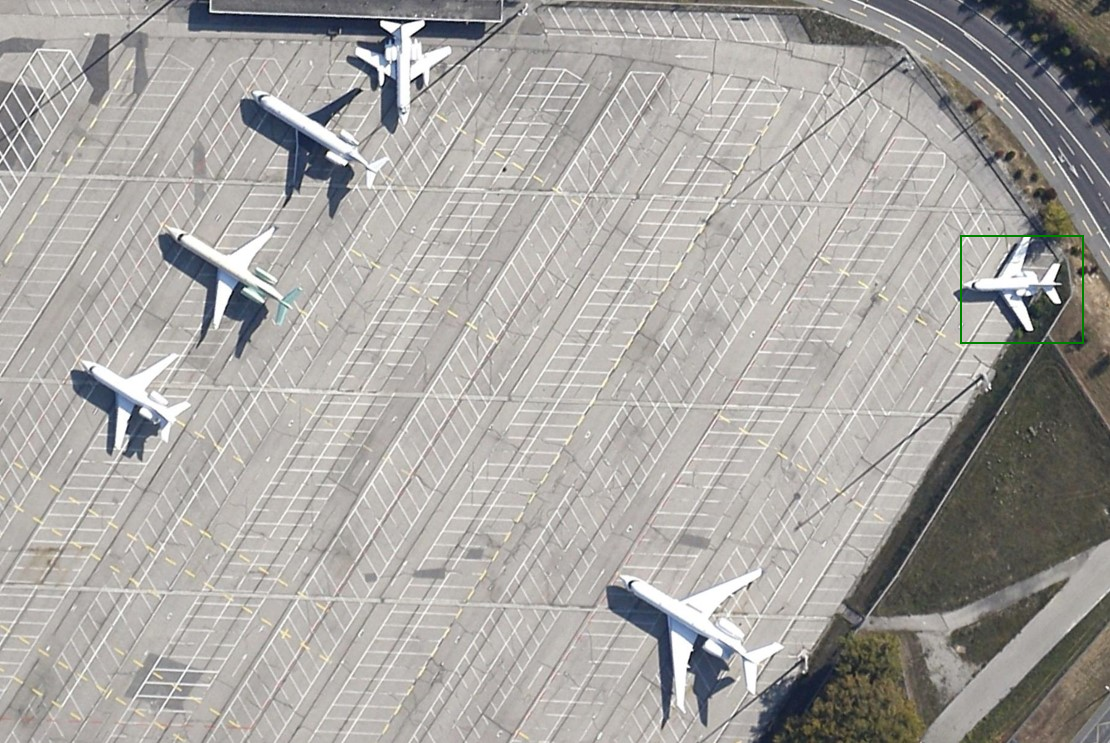

In [1]:
from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image, ImageDraw
import torch
from pycallgraph2 import PyCallGraph
from pycallgraph2.output import GraphvizOutput
# F:\chrome\R.jpg
graphviz = GraphvizOutput()
graphviz.output_file = 'basic.png'#图片名称

with PyCallGraph(output=graphviz):
    image = Image.open(r"F:\\2023\\objectDetection\\plane_many.jpg")
    
    model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
    image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")
    
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    
    # model predicts bounding boxes and corresponding COCO classes
    logits = outputs.logits
    bboxes = outputs.pred_boxes
    
    
    # print results
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}")
        # Create drawable image
        draw = ImageDraw.Draw(image) 
        # Draw rectangle
        draw.rectangle(box, outline="green", width=2)
    
    # Display image
    display(image)